# Meta-Analytic Subtraction Analysis

In [1]:
# First, import the necessary modules and functions
import os

import matplotlib.pyplot as plt
from myst_nb import glue
from nilearn import image, plotting

import nimare

# Define where data files will be located
DATA_DIR = os.path.abspath("../data")
FIG_DIR = os.path.abspath("../images")

# Now, load the Datasets we will use in this chapter
sleuth_dset1 = nimare.dataset.Dataset.load(os.path.join(DATA_DIR, "sleuth_dset1.pkl.gz"))
sleuth_dset2 = nimare.dataset.Dataset.load(os.path.join(DATA_DIR, "sleuth_dset2.pkl.gz"))

/home/data/nbc/misc-projects/Salo_NiMARE/conda_env/lib/python3.7/site-packages/nilearn/datasets/__init__.py:90: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


Subtraction analysis refers to the voxel-wise comparison of two meta-analytic samples.
In image-based meta-analysis, comparisons between groups of maps can generally be accomplished within the standard meta-regression framework (i.e., by adding a covariate that codes for group membership).
However, coordinate-based subtraction analysis requires special extensions for CBMA algorithms.

Subtraction analysis to compare the results of two ALE meta-analyses was originally implemented by {cite:t}`Laird2005-qh` and later extended by {cite:t}`Eickhoff2012-hk`.
In this approach, two groups of experiments (A and B) are compared using a group assignment randomization procedure in which voxel-wise null distributions are generated by randomly reassigning experiments between the two groups and calculating ALE-difference scores for each permutation.
Real ALE-difference scores (i.e., the ALE values for one group minus the ALE values for the other) are compared against these null distributions to determine voxel-wise significance.
In the original implementation of the algorithm, this procedure is performed separately for a group A > B contrast and a group B > A contrast, where each contrast is limited to voxels that were significant in the first group's original meta-analysis.

In NiMARE, we use an adapted version of the subtraction analysis method in {py:class}`nimare.meta.cbma.ale.ALESubtraction`.
Note that, unlike the original algorithm, the NiMARE implementation analyzes all voxels, rather than only those that show a significant effect of A alone or B alone.

In [2]:
from nimare import meta

kern = meta.kernel.ALEKernel()
sub_meta = meta.cbma.ale.ALESubtraction(kernel_transformer=kern, n_iters=10000)
sub_results = sub_meta.fit(sleuth_dset1, sleuth_dset2)

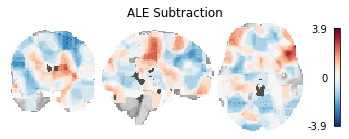

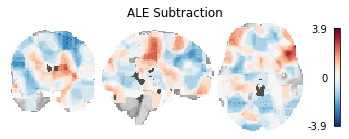

In [3]:
fig, ax = plt.subplots(figsize=(6, 2))
display = plotting.plot_stat_map(
    sub_results.get_map("z_desc-group1MinusGroup2", return_type="image"),
    annotate=False,
    axes=ax,
    cmap="RdBu_r",
    cut_coords=[0, 0, 0],
    draw_cross=False,
    figure=fig,
)
ax.set_title("ALE Subtraction")

colorbar = display._cbar
colorbar_ticks = colorbar.get_ticks()
if colorbar_ticks[0] < 0:
    new_ticks = [colorbar_ticks[0], 0, colorbar_ticks[-1]]
else:
    new_ticks = [colorbar_ticks[0], colorbar_ticks[-1]]
colorbar.set_ticks(new_ticks, update_ticks=True)
glue("figure_subtraction", fig, display=False)

```{glue:figure} figure_subtraction
:name: figure_subtraction
:align: center

An array of plots of the statistical maps produced by the meta-analysis.
```

Alternatively, MKDA Chi-squared analysis is inherently a subtraction analysis method, in that it compares foci from two groups of studies.
Generally, one of these groups is a sample of interest, while the other is a meta-analytic database (minus the studies in the sample).
With this setup, meta-analysts can infer whether there is greater convergence of foci in a voxel as compared to the baseline across the field (as estimated with the meta-analytic database), much like SCALE.
However, if the database is replaced with a second sample of interest, the analysis ends up comparing convergence between the two groups.